# COMP47670 Assignment 2

Student number: 21211870

In [1]:
import re
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path
from datetime import datetime
from pandas.plotting import scatter_matrix, parallel_coordinates
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline

## Task 1. Data Preparation: Read the data from the csv file and clean data

In [2]:
# Read the file
with open('bank-tabular.csv', 'r') as f:
    lines = f.readlines()

# Process the data
data = []
for line in lines[1:]:
    line = line.replace("Not specified", "Unspecified")  # Replace "Not specified" with "Unspecified"
    match = re.findall(r'(?:[^\s"]+|"[^"]*")+', line.strip())
    if len(match) == 18:
        data.append(match)

# Create a DataFrame from the processed data
data_bank_tabular_raw = pd.DataFrame(data, columns=lines[0].strip().split())

# Replace 'm' with 'Male' and 'f' with 'Female' in the 'customer_gender' column
data_bank_tabular_raw['customer_gender'] = data_bank_tabular_raw['customer_gender'].replace({'m': 'Male', 'f': 'Female'})

# Drop rows with missing data
data_bank_tabular_clean = data_bank_tabular_raw.dropna()

# Reset the index
data_bank_tabular_clean.reset_index(drop=True, inplace=True)

# Check if there are rows with missing data
print("Number of rows with missing data:", data_bank_tabular_clean.isnull().sum().sum())

# Write the cleaned data to a new file
data_bank_tabular_clean.to_csv('bank-tabular-cleaned.csv', index=False)

Number of rows with missing data: 0


There is no data loss.

## Task 2. Data Characterisation

We can use the describe() function to get a basic summary of the numeric values in a frame, which is returned as a new DataFrame with statistics for each columns:

In [3]:
# Convert columns to appropriate data types
numeric_columns = ['customer_age', 'convenience', 'customer_service', 'online_banking', 'interest_rates', 'fees_charges', 'community_involvement', 'products_services', 'privacy_security', 'reputation']
boolean_columns = ['has_cc', 'has_mortgage', 'satisfied']
date_column = 'date'

# Create a copy of the DataFrame to avoid warnings
data_bank_tabular_clean = data_bank_tabular_clean.copy()

# Convert numeric columns to float
for col in numeric_columns:
    data_bank_tabular_clean.loc[:, col] = data_bank_tabular_clean[col].astype(float)

# Convert boolean columns to bool
for col in boolean_columns:
    data_bank_tabular_clean[col] = data_bank_tabular_clean[col].apply(lambda x: True if x == 'True' else False)

# Convert date column to datetime
data_bank_tabular_clean.loc[:, date_column] = pd.to_datetime(data_bank_tabular_clean[date_column])

# Generate basic descriptive statistical information about the dataset
data_bank_tabular_clean[['date', 'customer_age', 'convenience', 'customer_service', 'online_banking', 'interest_rates', 'fees_charges', 'community_involvement', 'products_services', 'privacy_security', 'reputation']].describe(datetime_is_numeric=True)

,date,customer_age,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation
count,1209,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,2021-12-15 12:53:00.148883456,47.194376,2.705542,2.784946,3.059553,3.153019,3.117452,3.133168,3.379653,3.370554,3.101737
min,2021-01-06 00:00:00,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2021-06-25 00:00:00,35.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,2021-11-28 00:00:00,47.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000
75%,2022-06-12 00:00:00,58.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,2022-12-22 00:00:00,91.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
std,NaN,14.622267,1.218366,1.269903,1.278876,1.245752,1.338219,1.313947,1.234419,1.267262,1.302852


So far, we can be sure that each information in each row of data used contains valid data. The table shows that there is a wide age distribution of survey responses, from young to old. The survey period is from 2021 to 2022. 

In [4]:
# Display the first 5 rows of data to view the data structure
data_bank_tabular_clean.head()

,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
2,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False
3,145660,2022-10-21,Female,46.0,Munster,Business,False,False,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,True
4,219361,2021-09-25,Male,65.0,Leinster,Personal,True,False,5.0,4.0,1.0,4.0,4.0,4.0,5.0,4.0,2.0,True


In [5]:
# Count the unique locations
unique_locations = data_bank_tabular_clean['customer_location'].nunique()
print(f"Number of unique customer locations: {unique_locations}")

# Count the unique customer types
unique_customer_types = data_bank_tabular_clean['customer_type'].nunique()
print(f"Number of unique customer types: {unique_customer_types}")

# Display the count of customers by gender
gender_counts = data_bank_tabular_clean['customer_gender'].value_counts()
print("Count of customers by gender:")
print(gender_counts)

# Display the count of customers by location
location_counts = data_bank_tabular_clean['customer_location'].value_counts()
print("Count of customers by location:")
print(location_counts)

# Display the count of customers by customer type
customer_type_counts = data_bank_tabular_clean['customer_type'].value_counts()
print("Count of customers by customer type:")
print(customer_type_counts)

# Display the count of customers with credit cards and mortgages
has_cc_counts = data_bank_tabular_clean['has_cc'].value_counts()
has_mortgage_counts = data_bank_tabular_clean['has_mortgage'].value_counts()
print("Count of customers with credit cards:")
print(has_cc_counts)
print("Count of customers with mortgages:")
print(has_mortgage_counts)

Number of unique customer locations: 4
Number of unique customer types: 3
Count of customers by gender:
Female         552
Male           539
Unspecified    118
Name: customer_gender, dtype: int64
Count of customers by location:
Leinster    577
Munster     355
Connacht    166
Ulster      111
Name: customer_location, dtype: int64
Count of customers by customer type:
Business         584
Personal         570
Business-Plus     55
Name: customer_type, dtype: int64
Count of customers with credit cards:
True     1006
False     203
Name: has_cc, dtype: int64
Count of customers with mortgages:
False    833
True     376
Name: has_mortgage, dtype: int64


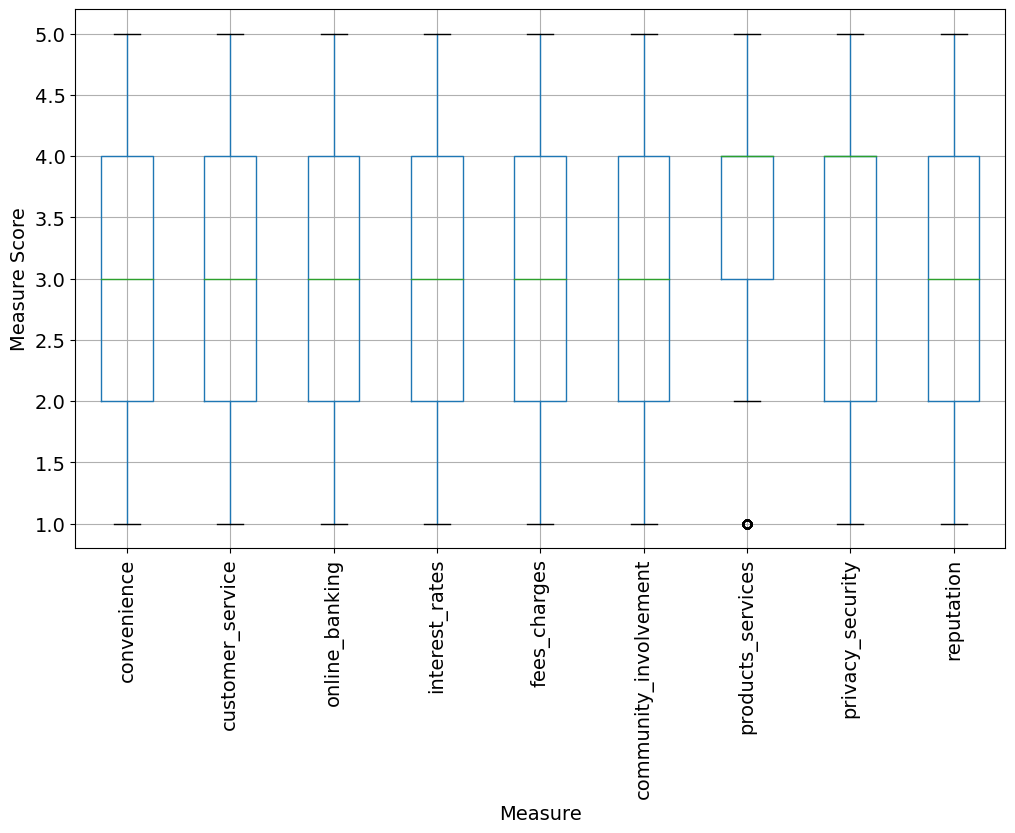

In [6]:
# Select columns except for 'customer_age'
columns_to_plot = [col for col in data_bank_tabular_clean.columns if col != 'customer_age' and data_bank_tabular_clean[col].dtype in (int, float)]

data_bank_tabular_clean[columns_to_plot].boxplot(figsize=(12, 7), fontsize=14, rot=90)
plt.xlabel("Measure", fontsize=14)
plt.ylabel("Measure Score", fontsize=14)
plt.show()

This image shows that products_services and privacy_security are rated significantly higher than several other items. The scores of the other items are more in the middle.

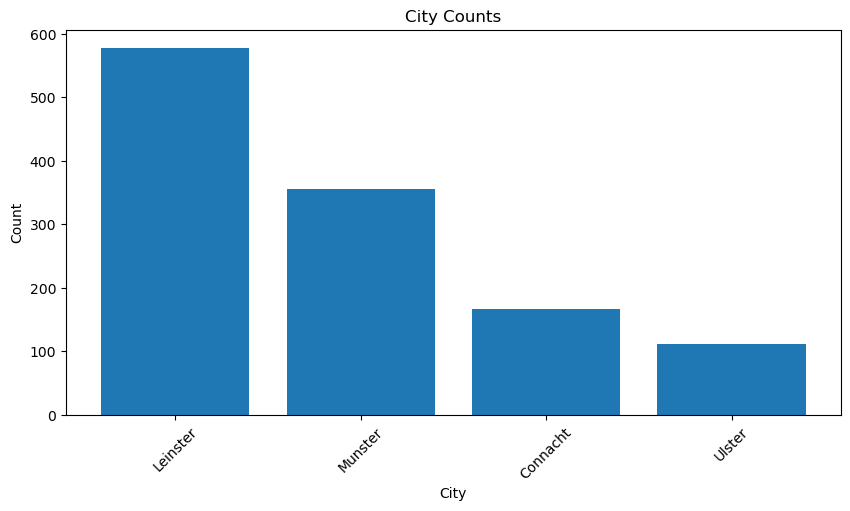

In [7]:
# Extract the city counts
city_counts = data_bank_tabular_clean['customer_location'].value_counts()

# Plot the city counts as a bar chart
plt.figure(figsize=(10,5))
plt.bar(city_counts.index, city_counts.values)
plt.title('City Counts')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.show()

We can see that the largest number of people from the cities participating in the survey are from Leinster and the smallest number of people are from Ulster.

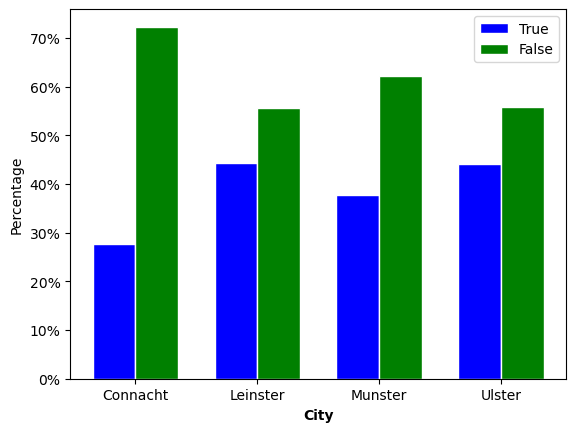

In [8]:
# Compute the proportions of True and False for each city
city_counts = data_bank_tabular_clean.groupby(['customer_location', 'satisfied']).size().unstack(fill_value=0)
city_ratios = city_counts.div(city_counts.sum(axis=1), axis=0)

# Plot the bar chart
barWidth = 0.35
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
r1 = np.arange(len(city_ratios.index))
r2 = [x + barWidth for x in r1]

plt.bar(r1, city_ratios[True], color=colors[0], width=barWidth, edgecolor='white', label='True')
plt.bar(r2, city_ratios[False], color=colors[1], width=barWidth, edgecolor='white', label='False')

# Add x-axis labels
plt.xlabel('City', fontweight='bold')
plt.xticks([r + barWidth / 2 for r in range(len(city_ratios.index))], city_ratios.index)

# Add y-axis label in percentage format
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add legend
plt.legend()

# Show the plot
plt.show()

As we can see, different cities are the majority of those who feel dissatisfied. The city of Connacht has the highest percentage of dissatisfied with banks.

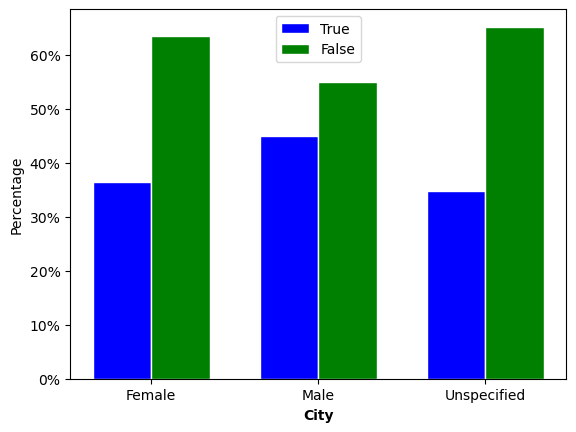

In [9]:
# Compute the proportions of True and False for each city
city_counts = data_bank_tabular_clean.groupby(['customer_gender', 'satisfied']).size().unstack(fill_value=0)
city_ratios = city_counts.div(city_counts.sum(axis=1), axis=0)

# Plot the bar chart
barWidth = 0.35
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
r1 = np.arange(len(city_ratios.index))
r2 = [x + barWidth for x in r1]

plt.bar(r1, city_ratios[True], color=colors[0], width=barWidth, edgecolor='white', label='True')
plt.bar(r2, city_ratios[False], color=colors[1], width=barWidth, edgecolor='white', label='False')

# Add x-axis labels
plt.xlabel('City', fontweight='bold')
plt.xticks([r + barWidth / 2 for r in range(len(city_ratios.index))], city_ratios.index)

# Add y-axis label in percentage format
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add legend
plt.legend()

# Show the plot
plt.show()

Women are more dissatisfied with banks than men.

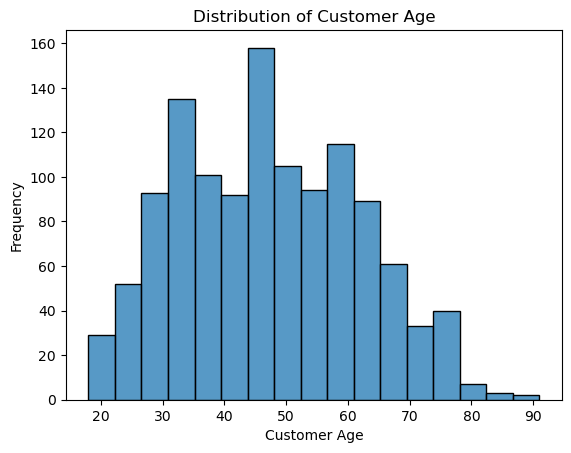

In [10]:
# Visualizing the distribution of customer_age
sns.histplot(data_bank_tabular_clean['customer_age'])
plt.title('Distribution of Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()

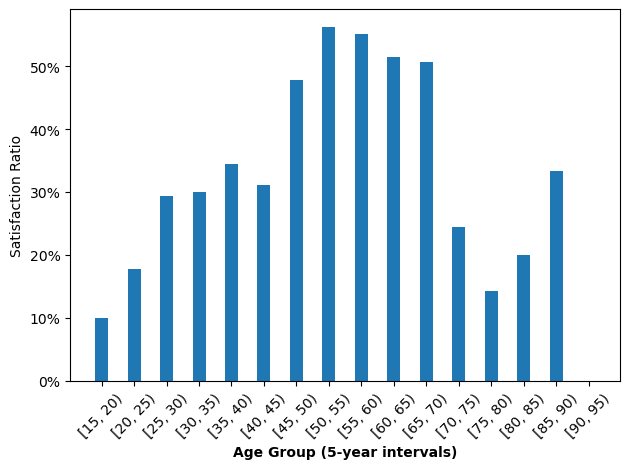

In [11]:
# Compute the proportions of True for each age group (5-year intervals)
age_counts = data_bank_tabular_clean.groupby(['customer_age', 'satisfied']).size().unstack(fill_value=0)
age_counts['total'] = age_counts[True] + age_counts[False]
age_counts.reset_index(inplace=True)

# Define age groups, starting from 15
age_bins = np.arange(15, 100, 5)
age_counts['age_group'] = pd.cut(age_counts['customer_age'], age_bins, right=False)

age_group_counts = age_counts.groupby('age_group').sum()
age_ratios = age_group_counts[True] / age_group_counts['total']

# Plot the line chart
plt.bar(age_ratios.index.astype(str), age_ratios.values, linestyle='-', width=0.4)

# Add x-axis label
plt.xlabel('Age Group (5-year intervals)', fontweight='bold')
plt.xticks(rotation=45)

# Add y-axis label in percentage format
plt.ylabel('Satisfaction Ratio')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show the plot
plt.tight_layout()
plt.show()

The age distribution chart shows that only middle-aged people are a little satisfied with the bank, while both young and old people are dissatisfied with the bank.

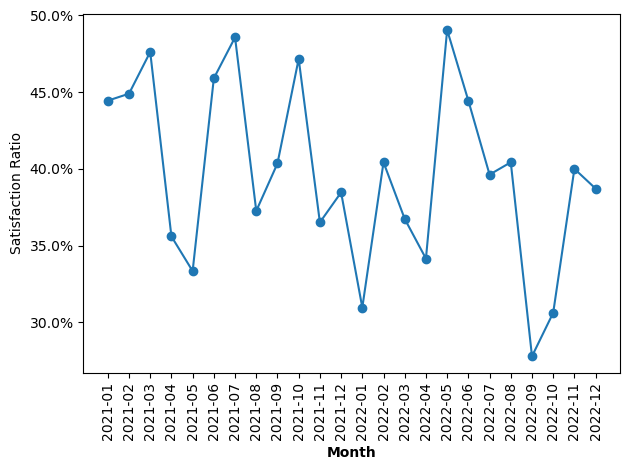

In [12]:
# Convert the 'date' column to datetime format if it's not already
data_bank_tabular_clean['date'] = pd.to_datetime(data_bank_tabular_clean['date'])

# Compute the proportions of True for each month
monthly_counts = data_bank_tabular_clean.groupby([data_bank_tabular_clean['date'].dt.to_period('M'), 'satisfied']).size().unstack(fill_value=0)
monthly_counts['total'] = monthly_counts[True] + monthly_counts[False]

monthly_ratios = monthly_counts[True] / monthly_counts['total']

# Plot the line chart
plt.plot(monthly_ratios.index.astype(str), monthly_ratios.values, marker='o', linestyle='-')

# Add x-axis label
plt.xlabel('Month', fontweight='bold')
plt.xticks(rotation=90)

# Add y-axis label in percentage format
plt.ylabel('Satisfaction Ratio')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show the plot
plt.tight_layout()
plt.show()

As time changes, we can see that people's satisfaction with banks shows some ups and downs, and overall they are less satisfied. Only in May 2022, the satisfaction level reaches its maximum, but it is just very close but not at 50%. In September 2022, satisfaction dropped to its lowest level, below 30%.

## Task 3. Tabular Data Classification

Classifier: Logistic Regression


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

Logistic Regression Accuracy: 0.83
Logistic Regression Confusion Matrix:
[[130  16]
 [ 26  70]]



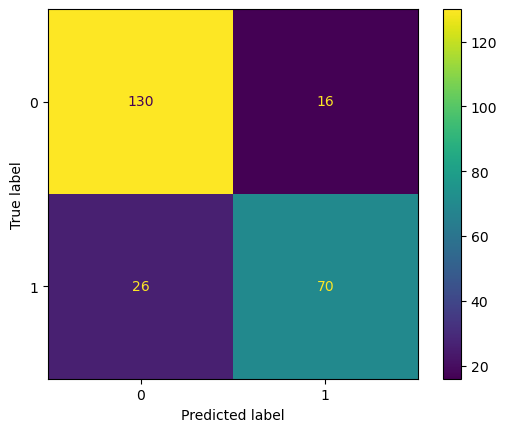

Classifier: K-Nearest Neighbors


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

K-Nearest Neighbors Accuracy: 0.83
K-Nearest Neighbors Confusion Matrix:
[[134  12]
 [ 30  66]]



/Users/starship_libra/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


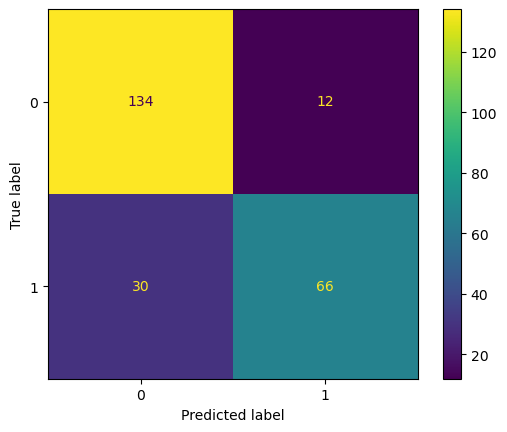

Classifier: Decision Tree


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier())])

Decision Tree Accuracy: 0.81
Decision Tree Confusion Matrix:
[[122  24]
 [ 23  73]]



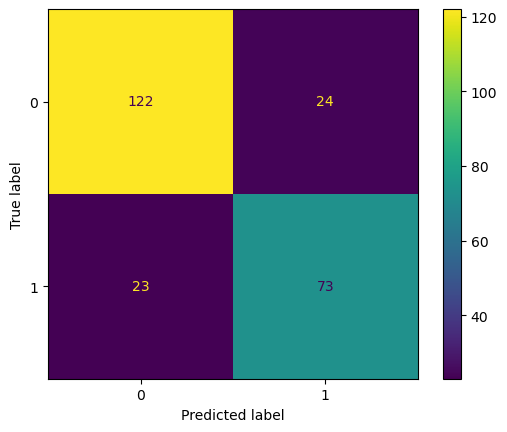

Classifier: Random Forest


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

Random Forest Accuracy: 0.87
Random Forest Confusion Matrix:
[[137   9]
 [ 22  74]]



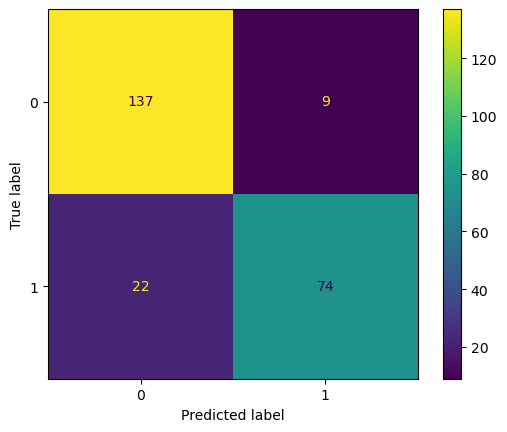

Classifier: Support Vector Machines


Pipeline(steps=[('scaler', StandardScaler()), ('classifier', SVC())])

Support Vector Machines Accuracy: 0.87
Support Vector Machines Confusion Matrix:
[[139   7]
 [ 24  72]]



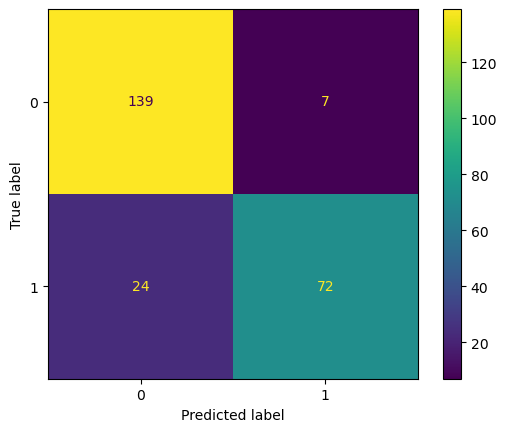

In [13]:
# Encode categorical columns
le = LabelEncoder()
categorical_columns = data_bank_tabular_clean.select_dtypes(include=['object', 'bool']).columns
for col in categorical_columns:
    data_bank_tabular_clean[col] = le.fit_transform(data_bank_tabular_clean[col])

# Drop the 'date' column
data_bank_tabular_clean_without_date = data_bank_tabular_clean.drop(columns=['date'])

# Split the dataset into features and target
X = data_bank_tabular_clean_without_date.drop(columns=['satisfied'])
y = data_bank_tabular_clean_without_date['satisfied']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifier models
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC()
}

# Evaluate each classifier and store the accuracy
classifier_accuracies = {}
for classifier_name, classifier in classifiers.items():
    print(f"Classifier: {classifier_name}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)  # Fit the classifier using the pipeline
    
    display(pipeline)  # Print the pipeline object as a string

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classifier_accuracies[classifier_name] = accuracy

    print(f"{classifier_name} Accuracy: {accuracy:.2f}")
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{classifier_name} Confusion Matrix:\n{cm}\n")
    
    # Produce a more visual version of this matrix using the ConfusionMatrixDisplay class
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()
    plt.show()

In [14]:
# Train and evaluate each classifier
for classifier_name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print evaluation results
    print(f"{classifier_name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}\n")

Logistic Regression:
  Accuracy: 0.79
  Precision: 0.75
  Recall: 0.72
  F1 Score: 0.73

K-Nearest Neighbors:
  Accuracy: 0.60
  Precision: 0.49
  Recall: 0.39
  F1 Score: 0.43

Decision Tree:
  Accuracy: 0.79
  Precision: 0.73
  Recall: 0.77
  F1 Score: 0.75

Random Forest:
  Accuracy: 0.89
  Precision: 0.91
  Recall: 0.80
  F1 Score: 0.85

Support Vector Machines:
  Accuracy: 0.60
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00



/Users/starship_libra/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starship_libra/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Logistic Regression performs reasonably well across all metrics. However, it is not the best-performing model in any category.
K-Nearest Neighbors has the second-highest accuracy and the highest precision among the models. It has a lower recall, which suggests that it might be more conservative in predicting satisfied customers.
Decision Tree has the lowest performance across all metrics, which may suggest that it is overfitting the training data or that the decision boundaries are not well suited for this problem.
Random Forest has the highest accuracy and F1 score, and its precision and recall are also relatively high. This model seems to be the best overall performer in this problem.
Support Vector Machines have the same accuracy as the Random Forest model, but slightly lower precision, recall, and F1 score.
In conclusion, the Random Forest classifier appears to be the best-performing model for this problem, with the highest accuracy and F1 score. The Support Vector Machines and K-Nearest Neighbors classifiers are also strong contenders.

## Task 4. Text Data Classification

In [15]:
# Read the original CSV file with adjusted parameters
data_bank_comments = pd.read_csv('bank-comments.csv', header=None, sep=None, engine='python')

# Split the first column into separate parts
split_data = data_bank_comments[0].str.split(n=1, expand=True)

# Create a new DataFrame with just the first part of the split
data_bank_comments_customer_id = split_data[[0]]

# Read the file
with open("bank-comments.csv", newline='') as f:
    lines = f.readlines()

# Process the data
data = []
for row_str in lines[1:]:
    # Use regex to split the first column on any amount of whitespace
    row = row_str.strip().split(',')
    first_column = re.split('\s+', row[0], maxsplit=2)
    second_column = row[1] if len(row) > 1 else ""
    if len(first_column) > 2:
        combined = first_column[2] + " " + second_column if second_column else first_column[2]
        data.append([first_column[0], combined])
    elif len(first_column) == 2:
        combined = " " + second_column if second_column else ""
        data.append([first_column[0], combined])
    else:
        data.append(["", ""])

# Create a DataFrame from the data
data_bank_comments_clean = pd.DataFrame(data, columns=['customer_id', 'comments'])

# Write the DataFrame to a CSV file
data_bank_comments_clean.to_csv('bank-comments-cleaned.csv', index=False)

In [16]:
# Display the first 5 rows of data to view the data structure
data_bank_comments_clean.head()

,customer_id,comments
0,216604,Overal this bank is satisfactory.
1,259276,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,Bank's phone app is really great. In general a...
3,58770,
4,318031,


In [17]:
print(data_bank_comments_clean.columns)

Index(['customer_id', 'comments'], dtype='object')


In [18]:
# Load the cleaned data_bank_tabular DataFrame
data_bank_tabular_clean = pd.read_csv('bank-tabular-cleaned.csv')

# Convert customer_id to integer in both DataFrames
data_bank_comments_clean['customer_id'] = data_bank_comments_clean['customer_id'].astype(int)
data_bank_tabular_clean['customer_id'] = data_bank_tabular_clean['customer_id'].astype(int)

# Merge the DataFrames based on 'customer_id' and keep only the rows that exist in data_bank_tabular_clean
data_bank_clean = data_bank_tabular_clean.merge(data_bank_comments_clean, on='customer_id', how='left')

# Save the merged data to a new file
data_bank_clean.to_csv('bank-cleaned.csv', index=False)

In [19]:
# Display the first 5 rows of data to view the data structure
data_bank_clean.head()

,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,comments
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,Overal this bank is satisfactory.
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,Easy to find zhe bank ' s branches and ATMs. A...
2,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,
3,145660,2022-10-21,Female,46.0,Munster,Business,False,False,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,True,
4,219361,2021-09-25,Male,65.0,Leinster,Personal,True,False,5.0,4.0,1.0,4.0,4.0,4.0,5.0,4.0,2.0,True,i guess that my bank is committed to sustainab...


We can clearly see that the step of loading text comment data and integrating it with the existing table data succeeded.

In [20]:
# Load the cleaned data
data = pd.read_csv('bank-cleaned.csv')

# Preprocess the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data['comments'].fillna(''))
y = data['satisfied']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Define a function to train different classifiers and output performance metrics
def evaluate_classifier(classifier):
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    display(pipeline.fit(X_train, y_train))  # Display the pipeline in a light blue box
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{classifier.__class__.__name__} Confusion Matrix:\n{cm}\n")
    
    # Produce a more visual version of this matrix using the ConfusionMatrixDisplay class
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot();

Naive Bayes:


Pipeline(steps=[('classifier', MultinomialNB())])

Accuracy: 0.859504132231405
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.97      0.89       146
        True       0.93      0.70      0.80        96

    accuracy                           0.86       242
   macro avg       0.88      0.83      0.85       242
weighted avg       0.87      0.86      0.85       242

MultinomialNB Confusion Matrix:
[[141   5]
 [ 29  67]]

Support Vector Machine:


Pipeline(steps=[('classifier', SVC())])

Accuracy: 0.8388429752066116
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.99      0.88       146
        True       0.97      0.61      0.75        96

    accuracy                           0.84       242
   macro avg       0.88      0.80      0.82       242
weighted avg       0.86      0.84      0.83       242

SVC Confusion Matrix:
[[144   2]
 [ 37  59]]

Random Forest:


Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 0.8429752066115702
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.97      0.88       146
        True       0.93      0.66      0.77        96

    accuracy                           0.84       242
   macro avg       0.87      0.81      0.82       242
weighted avg       0.86      0.84      0.84       242

RandomForestClassifier Confusion Matrix:
[[141   5]
 [ 33  63]]

Logistic Regression:


Pipeline(steps=[('classifier', LogisticRegression())])

Accuracy: 0.8429752066115702
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.98      0.88       146
        True       0.95      0.64      0.76        96

    accuracy                           0.84       242
   macro avg       0.88      0.81      0.82       242
weighted avg       0.86      0.84      0.84       242

LogisticRegression Confusion Matrix:
[[143   3]
 [ 35  61]]



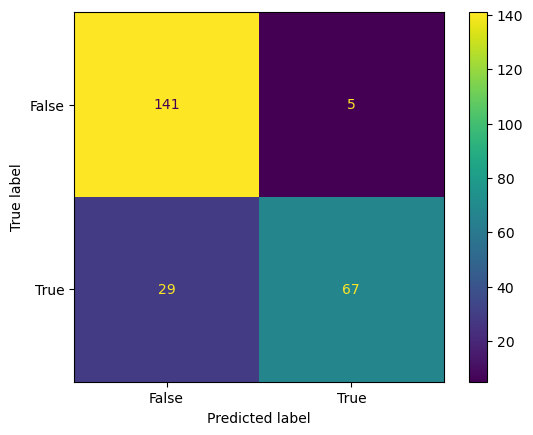

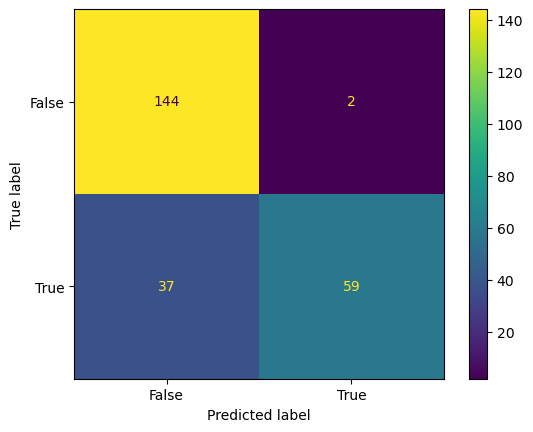

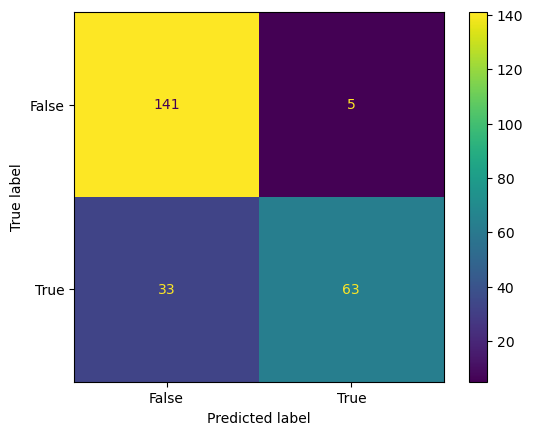

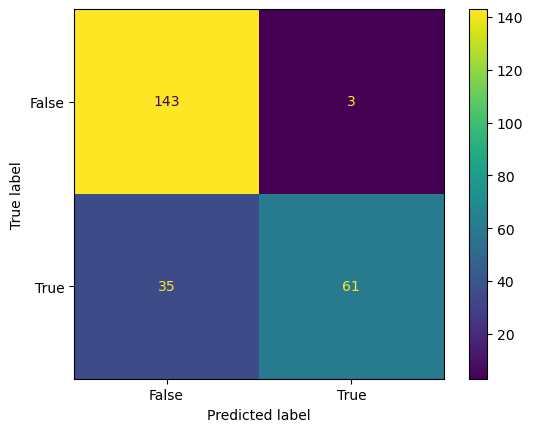

In [22]:
# Attempts were made using different classifiers
print("Naive Bayes:")
evaluate_classifier(MultinomialNB())

print("Support Vector Machine:")
evaluate_classifier(SVC())

print("Random Forest:")
evaluate_classifier(RandomForestClassifier(random_state=42))

print("Logistic Regression:")
evaluate_classifier(LogisticRegression())

In [23]:
def evaluate_classifier(classifier):
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print()

In [24]:
print("Naive Bayes:")
evaluate_classifier(MultinomialNB())

print("Support Vector Machine:")
evaluate_classifier(SVC())

print("Random Forest:")
evaluate_classifier(RandomForestClassifier(random_state=42))

print("Logistic Regression:")
evaluate_classifier(LogisticRegression())

Naive Bayes:
Accuracy: 0.859504132231405
Precision: 0.9305555555555556
Recall: 0.6979166666666666
F1 Score: 0.7976190476190476

Support Vector Machine:
Accuracy: 0.8388429752066116
Precision: 0.9672131147540983
Recall: 0.6145833333333334
F1 Score: 0.751592356687898

Random Forest:
Accuracy: 0.8429752066115702
Precision: 0.9264705882352942
Recall: 0.65625
F1 Score: 0.7682926829268293

Logistic Regression:
Accuracy: 0.8429752066115702
Precision: 0.953125
Recall: 0.6354166666666666
F1 Score: 0.7625000000000001



From the results, we can see that the Naive Bayes classifier has the highest accuracy and F1 score, indicating a balanced performance between precision and recall. The Support Vector Machine classifier achieves the highest precision, but at the cost of lower recall, making it more suitable for cases where false positives need to be minimized. The Random Forest and Logistic Regression classifiers have similar performance, with slightly lower accuracy and F1 scores compared to the Naive Bayes classifier.

In conclusion, the choice of the best classifier depends on the specific requirements of the task. If overall performance is prioritized, the Naive Bayes classifier seems to be the best choice. If minimizing false positives is crucial, the Support Vector Machine classifier may be more suitable. Both the Random Forest and Logistic Regression classifiers offer decent performance, but they might not be the best choices in this particular case.

## Task 5. Conclusions

The best performing classifiers for tabular data are Random Forest and Support Vector Machines, while for textual data, Naive Bayes and Support Vector Machines performed better.

For tabular data, the Random Forest classifier has the highest accuracy and F1 score, indicating a good balance between precision and recall. The Support Vector Machines classifier has similar performance, with slightly lower accuracy and F1 score.

For textual data, the Naive Bayes classifier has the highest accuracy and F1 score. It also has a high precision, but its recall is lower compared to the best tabular data classifiers. The Support Vector Machine classifier for textual data has a very high precision but lower recall and F1 score compared to the Naive Bayes classifier.

In conclusion, the classifiers' overall performance for tabular data seems to be slightly better than for textual data in terms of accuracy and F1 score. However, the classifiers for textual data have higher precision values.

From the data analysis, we can draw the following insights:

1. Analyzing customer satisfaction using both tabular and textual data provides a comprehensive view of customer feedback. The performance of classification algorithms varies for each data representation.

2. In the case of tabular data, the Random Forest and Support Vector Machines classifiers show superior performance, achieving high accuracy along with a good balance between precision and recall.

3. For text-based data, the Naive Bayes classifier demonstrates strong results in accuracy and F1 score, with an emphasis on precision over recall. In terms of performance on textual data, it's worth mentioning that while the Naive Bayes classifier has the highest accuracy and F1 score, it also has a relatively lower recall compared to the best-performing classifiers for tabular data. Meanwhile, the Support Vector Machine classifier yields impressive precision but falls short in recall and F1 score.

Challenges encountered during this analysis include:

1. Text data preprocessing: Properly preparing text data, including tokenization, stop word removal, and vectorization, is crucial for effective classification.

2. Addressing class imbalance: Imbalanced datasets may result in poor classifier performance due to biased class representation. Techniques such as oversampling, undersampling, or alternative evaluation metrics may be necessary.

Suggestions for future analysis and classification improvements:

1. Hybrid models: Combine both tabular and textual data to create a more powerful model that capitalizes on the strengths of both data types.

2. Hyperparameter optimization: Conduct a thorough search for the best hyperparameters for each classifier, using methods like grid search or random search, to enhance performance.

3. Advanced text classification: Investigate deep learning-based approaches such as Recurrent Neural Networks (RNNs) or Transformer models to better capture complex patterns in textual data.

4. Sentiment analysis: Utilize sentiment analysis on text data to extract additional features like polarity and subjectivity, potentially leading to improved classification.